Created by Joan-Marc Fisa

- Numerai: [FisaGol](https://numer.ai/fisagol)

- Twitter: [@fisagol](https://twitter.com/fisagol)


In [ ]:
!pip install numerapi
!pip install catboost
!pip install vecstack;

     |████████████████████████████████| 65.8MB 104kB/s 
  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19880 sha256=1955ddf14ef0e9ee63e911d3755e51baed674c3969acc4d2775c2b2aca35d73b
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [ ]:
##################################################################
##################### LIBRARIES ##################################
##################################################################


In [ ]:
import os
import gc
import csv
import sys
import glob
import time
from pathlib import Path
from multiprocessing import Pool

import numerapi

import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import sklearn
from sklearn import (
    feature_extraction, feature_selection, decomposition, linear_model,
    model_selection, metrics, svm, preprocessing, utils
)
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OrdinalEncoder, LabelEncoder,OneHotEncoder
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Dense, Dropout, Activation,LSTM,Bidirectional, MaxPooling2D, Flatten,GRU
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from sklearn.model_selection import StratifiedKFold, GroupKFold, GridSearchCV,cross_val_score,KFold, RepeatedStratifiedKFold,train_test_split
from sklearn.metrics import log_loss, make_scorer, mean_squared_error,classification_report,accuracy_score
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils 
from sklearn import preprocessing
from xgboost import XGBRegressor 
from sklearn.cluster import KMeans
import matplotlib as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import math
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor 

import torch.nn as nn
import torch.nn.functional as F

from vecstack import stacking

from sklearn import metrics

from scipy import stats

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred) ** 0.5


In [ ]:
'''
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))
'''

'\n%tensorflow_version 2.x\nimport tensorflow as tf\nimport timeit\n\ndevice_name = tf.test.gpu_device_name()\nif device_name != \'/device:GPU:0\':\n  print(\n      \'\n\nThis error most likely means that this notebook is not \'\n      \'configured to use a GPU.  Change this in Notebook Settings via the \'\n      \'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n\')\n  raise SystemError(\'GPU device not found\')\n\ndef cpu():\n  with tf.device(\'/cpu:0\'):\n    random_image_cpu = tf.random.normal((100, 100, 100, 3))\n    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)\n    return tf.math.reduce_sum(net_cpu)\n\ndef gpu():\n  with tf.device(\'/device:GPU:0\'):\n    random_image_gpu = tf.random.normal((100, 100, 100, 3))\n    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)\n    return tf.math.reduce_sum(net_gpu)\n  \n# We run each op once to warm up; see: https://stackoverflow.com/a/45067900\ncpu()\ngpu()\n\n# Run the op several times.\nprint(\'Time (s) to conv

In [ ]:
'''
# R 

random_slicer <- function(features, slice_percent){

  train_slice <- features[,4:313]
  feat_list <- sort(sample(1:310,round(310*slice_percent)))

  for(i in length(feat_list)){
      train_slice[,feat_list[i]] <- (-1)*(train_slice[,feat_list[i]] - 0.5) + 0.5
  }    
  train_slice  
}
'''

'\n# R \n\nrandom_slicer <- function(features, slice_percent){\n\n  train_slice <- features[,4:313]\n  feat_list <- sort(sample(1:310,round(310*slice_percent)))\n\n  for(i in length(feat_list)){\n      train_slice[,feat_list[i]] <- (-1)*(train_slice[,feat_list[i]] - 0.5) + 0.5\n  }    \n  train_slice  \n}\n'

In [ ]:
#https://pytorch.org/docs/stable/generated/torch.nn.Module.html
##https://forum.numer.ai/t/feature-reversing-input-noise/1416

## To be used on input to neural network. Make sure input is centered at 0!

class FeatureReversalNoise(nn.Module):
    def __init__(self, p=0.25):
        super(FeatureReversalNoise, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("probability has to be between 0 and 1, " "but got {}".format(p))
        self.p = p

    def forward(self, x):
        if self.training:
            binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
            noise = 2*binomial.sample((1,x.shape[1])) - 1
            return x * noise.cuda()
        else:
            return x

# This is used to add noise to neural net activations. It differs from the Gaussian Dropout suggested
# in the original Dropout paper in that the scale of the noise is proportional to the activation such
# that activation level equals the variance of noise (times alpha). Kinda like how real neurons have 
# Poisson-ish noise

class CoupledGaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(CoupledGaussianDropout, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        if self.training:
            stddev = torch.sqrt(torch.clamp(torch.abs(x), min=1e-6)).detach()
            epsilon = torch.randn_like(x) * self.alpha

            epsilon = epsilon * stddev

            return x + epsilon
        else:
            return x

In [ ]:
##############################################################################
########################## DOWLOAD DATA ######################################
##############################################################################

In [ ]:
seed = 3
rand = np.random.seed(seed)

In [ ]:
napi = numerapi.NumerAPI(verbosity="info")

napi.download_current_dataset(unzip=True)

current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

./numerai_dataset_250.zip: 390MB [00:07, 54.8MB/s]                           
2021-02-07 19:05:16,783 INFO numerapi.base_api: unzipping file...


In [ ]:
##################################################################
##################### LOAD DATA ##################################
##################################################################

In [ ]:
%%time
print("# Loading data...")

training_data = pd.read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
tournament_data = pd.read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")
validation_data = tournament_data[tournament_data.data_type == "validation"]

print("# All Loaded...")

# Loading data...
# All Loaded...
CPU times: user 1min 8s, sys: 11.3 s, total: 1min 19s
Wall time: 1min 21s


In [ ]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

Loaded 310 features


In [ ]:
'''
##################### CLASSES AND FUNCTIONS ##################################
'''
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)

def standardize_data(df):
    scaler = RobustScaler()
    data = scaler.fit_transform(df)
    return data
#https://joedorfman.github.io/2018/numerai/

def my_loss_fn_1(y_true, y_pred):
    loss = tf.keras.losses.poisson(y_true, y_pred)
    return loss


def my_loss_fn_2(y_true, y_pred):
    threshold = 1     
    error = y_true - y_pred     
    is_small_error = tf.abs(error) <= threshold     
    small_error_loss = tf.square(error) / 2     
    big_error_loss = threshold * (tf.abs(error) - (0.5 * threshold))
    return tf.where(is_small_error, small_error_loss, big_error_loss)

def my_loss_fn_3(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)


def rank_correlation(y_true, y_pred):
    return np.nan_to_num(stats.spearmanr(y_true, y_pred, axis=1)[0], nan=-1)


def rmsle_1(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False

def rae_1(y_true, y_pred):
    return 'RAE', np.sum(np.abs(y_pred - y_true)) / np.sum(np.abs(np.mean(y_true) - y_true)), False


#https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py
#https://github.com/chricke/Numerai-Keras/tree/master
#https://forum.numer.ai/t/example-for-using-tensorflow-keras-with-a-custom-callback/855


'''
y_pred=[…]
y_true=[…]
corr_coefs=[…] #310 correlation coefficients with y_pred

mse= mean(square(y_pred - y_true)
correlation_penalty= square(std(abs(corr_coefs)))
loss= mse + correlation_penalty
'''

'\ny_pred=[…]\ny_true=[…]\ncorr_coefs=[…] #310 correlation coefficients with y_pred\n\nmse= mean(square(y_pred - y_true)\ncorrelation_penalty= square(std(abs(corr_coefs)))\nloss= mse + correlation_penalty\n'

In [ ]:
import torch
from torch.autograd import grad

# define adjusted sharpe in terms of cost adjusted numerai sharpe
def numerai_sharpe(x):
    return (x.mean() -0.010415154) / x.std()

def skew(x):
    mx = x.mean()
    m2 = ((x-mx)**2).mean()
    m3 = ((x-mx)**3).mean()
    return m3/(m2**1.5)    

def kurtosis(x):
    mx = x.mean()
    m4 = ((x-mx)**4).mean()
    m2 = ((x-mx)**2).mean()
    return (m4/(m2**2))-3

def adj_sharpe(x):
    return numerai_sharpe(x) * (1 + ((skew(x) / 6) * numerai_sharpe(x)) - ((kurtosis(x) / 24) * (numerai_sharpe(x) ** 2)))

# use correlation as the measure of fit
def corr(pred, target):
    pred_n = pred - pred.mean(dim=0)
    pred_n = pred_n / pred_n.norm(dim=0)

    target_n = target - target.mean(dim=0)
    target_n = target_n / target_n.norm(dim=0)
    l = torch.matmul(pred_n.T, target_n)
    return l

# definte a custom objective for XGBoost
def adj_sharpe_obj(ytrue, ypred):
    # convert to pytorch tensors
    ypred_th = torch.tensor(ypred, requires_grad=True)
    ytrue_th = torch.tensor(ytrue)
    all_corrs = []

    # get correlations in each era
    for ee in era_idx:
        score = corr(ypred_th[ee], ytrue_th[ee])
        all_corrs.append(score)

    all_corrs = torch.stack(all_corrs)

    # calculate adjusted sharpe using correlations
    loss = -adj_sharpe(all_corrs)
    print(f'Current loss:{loss}')

    # calculate gradient and convert to numpy
    loss_grads = grad(loss, ypred_th, create_graph=True)[0]
    loss_grads = loss_grads.detach().numpy()

    # return gradient and ones instead of Hessian diagonal
    return loss_grads, np.ones(loss_grads.shape)


In [ ]:
#############################################################################
########################   PREPARE DATA   ###################################
#############################################################################

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
%%time
std_scale_train = StandardScaler().fit(training_data[feature_names])
df_std_train = std_scale_train.transform(training_data[feature_names])

std_scale_tournament = StandardScaler().fit(tournament_data[feature_names])
df_std_tournament = std_scale_tournament.transform(tournament_data[feature_names])

std_scale_validation = StandardScaler().fit(validation_data[feature_names])
df_std_validation = std_scale_validation.transform(validation_data[feature_names])

CPU times: user 18.1 s, sys: 3.63 s, total: 21.7 s
Wall time: 21.7 s


In [ ]:
%%time
df_std_train_f = pd.DataFrame(df_std_train, columns=feature_names)
df_std_tournament_f = pd.DataFrame(df_std_tournament, columns=feature_names)
df_std_validation_f = pd.DataFrame(df_std_validation, columns=feature_names)

CPU times: user 1.19 ms, sys: 50 µs, total: 1.24 ms
Wall time: 1.08 ms


In [ ]:
%%time
df_train = training_data
df_val = validation_data
df_tournament = tournament_data

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.68 µs


In [ ]:
%%time
df_train[feature_names] = df_std_train_f.values

CPU times: user 19.6 s, sys: 2.57 s, total: 22.1 s
Wall time: 22.1 s


In [ ]:
%%time
df_val[feature_names] = df_std_validation_f.values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


CPU times: user 5.18 s, sys: 585 ms, total: 5.77 s
Wall time: 5.76 s


In [ ]:
%%time
df_tournament[feature_names] = df_std_tournament_f.values

CPU times: user 1min 4s, sys: 7.21 s, total: 1min 11s
Wall time: 1min 11s


In [ ]:
X = training_data[feature_names]
Y = training_data[training_data.columns[-1]]

le = LabelEncoder()
Y_enc = le.fit_transform(Y)

In [ ]:
#https://forum.numer.ai/t/model-diagnostics-risk-metrics/900

TOURNAMENT_NAME = "nomi"
TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"

BENCHMARK = 0
BAND = 0.2

#-----------------------------------------------------

# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0, 1]

# The payout function
def payout(scores):
    return ((scores - BENCHMARK) / BAND).clip(lower=-1, upper=1)


# Read the csv file into a pandas Dataframe
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)

In [ ]:
##################################################################
#####################   MORE METRICS   ###########################
##################################################################

In [ ]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

#Some evaluation metrics
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

#-----------------------------------------------------
def get_baisc_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    
    prefix=None
    scores = pd.Series(dtype=float)

    preds_ = df[PREDICTION_NAME]
    #Some checks for deciding between training and tournament data
    if isVal:
        #scores["tournament_corr_example_preds"] = spearmanr(preds_, example_preds[PREDICTION_NAME])
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------

    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.pyplot.savefig(f"{prefix}_{fig_name}")
    plt.pyplot.show()

    #-----------------------------------------------------
    
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()
    scores[f"{prefix}_less_than_half"] = (preds_<0.5).mean()
    scores[f"{prefix}_less_than_mean"] = (preds_<preds_.mean()).mean()

    scores[f"{prefix}_autocorrelation"] = ar1(era_scores)
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Median Correlation"] = np.median(era_scores)
    scores[f"{prefix}_Variance"] = np.var(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)
    scores[f"{prefix}_smart sharpe"] = smart_sharpe(era_scores)
    scores[f"{prefix}_Numerai sharpe"] = numerai_sharpe(era_scores)

    print(scores)
    del era_scores
    del preds_
    gc.collect()
    return scores


In [ ]:
def neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()

def calculate_feature_exposure(df, feature_names) -> list:
    exposures = []
    for feature_name in feature_names:
        exposures.append(spearmanr(df[feature_name], df[PREDICTION_NAME]))
        
    max_feat_exposure = np.max(np.abs(exposures))
    square_sum_feature_exposure = np.sum([e**2 for e in exposures])
    feature_exposure = np.std(exposures)

    #print(max_feat_exposure, square_sum_feature_exposure)

    return [feature_exposure, max_feat_exposure, square_sum_feature_exposure]


def get_more_metrics(df, feature_names, isVal=None) -> pd.Series:
    
    more_metrics = pd.Series(dtype=float)
    metric_prefix=None
    assert PREDICTION_NAME in df.columns

    if isVal is None:
        isVal = "validation" in df["data_type"].unique() #max CPU times: user 65.1 ms

    print(isVal)
    if isVal:
        df = df[df["data_type"]=="validation"]
        metric_prefix = VAL_EVAL_PREFIX
    else:
        metric_prefix = TRAIN_EVAL_PREFIX

    assert metric_prefix is not None

    #-----------------------------------------------------

    #per-era scores
    
    print("predicting per-era scores...")
    scores_per_era = df.groupby("era").apply(
        lambda df: spearmanr(df[PREDICTION_NAME], df[TARGET_NAME]))
    
    more_metrics[f"{metric_prefix}_var"] = scores_per_era.std()

    #-----------------------------------------------------
    
    #Neutralize
    #This takes a significant amount of memory for calculation
    print(df.shape)
    print("Neutralizing...")
    df[f"neutral_{PREDICTION_NAME}"] = neutralize(df, PREDICTION_NAME, feature_names)
    feature_neutral_mean = df.groupby("era").apply(
        lambda x: spearmanr(x["neutral_"+PREDICTION_NAME].values, x[TARGET_NAME])).mean()

    more_metrics[f"{metric_prefix}_feature_neutral_mean"] = feature_neutral_mean
    gc.collect()

    #-----------------------------------------------------
    print("Calculating Feature Exposure...")
    feature_exposure, max_feat_exposure, square_sum_feature_exposure = calculate_feature_exposure(df, feature_names)

    more_metrics[f"{metric_prefix}_feat_exposure"] = feature_exposure
    more_metrics[f"{metric_prefix}_max_feat_exposure"] = max_feat_exposure
    more_metrics[f"{metric_prefix}_square_sum_feature_exposure"] = square_sum_feature_exposure


    #-----------------------------------------------------
    print("Drawdown...")
    rolling_max = (scores_per_era+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (scores_per_era+1).cumprod()
    max_drawdown = (rolling_max - daily_value).max()

    more_metrics[f"{metric_prefix}_max_drawdown"] = max_drawdown

    return more_metrics

In [ ]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    training_preds = model.predict(training_data[feature_names].values)
    training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)

    tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)

    del training_preds
    del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_baisc_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    tr_more_metrics = get_more_metrics(training_data, feature_names ,isVal=False)
    gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)
    gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      tr_more_metrics, val_more_metrics,
                      ])
    

In [ ]:
#############################################################################
###########################  CREATING SOME MODELS  ##########################
#############################################################################

In [ ]:
models = dict()

# https://neptune.ai/blog/lightgbm-parameters-guide
# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py

#https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc
#https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
#https://scikit-learn.org/stable/modules/ensemble.html
#https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

#############################################################################################################

model_1 = LGBMRegressor()
models["mlp_1"] = model_1

'''
#https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/
#https://pytorch.org/docs/stable/generated/torch.nn.Module.html
#https://machinelearningmastery.com/super-learner-ensemble-in-python/
https://forum.numer.ai/t/model-diagnostics-feature-exposure/899


nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(len(feature_names),)),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 2, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 4, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 4, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 2, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss='mse', optimizer="adam", metrics=['mae', 'mse'])

models["keras_mlp_simple"] = nn_model


############################################################################################################

nn_model_1 = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(len(feature_names),)),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 1, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 4, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 4, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 1, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model_1.compile(loss=my_loss_fn_2, optimizer="adam", metrics=['mae', 'mse'])

models["keras_mlp_1"] = nn_model_1


############################################################################################################

nn_model_2 = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(len(feature_names),)),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 2, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 4, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 4, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(len(feature_names) // 2, activation="relu"),
                                       tf.keras.layers.Dropout(0.2),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model_2.compile(loss=my_loss_fn_2, optimizer="adam", metrics=['mae', 'mse'])

models["keras_mlp_2"] = nn_model_2

'''
#############################################################################################################

model_2 = LGBMRegressor(bagging_fraction = 0.94, feature_fraction = 0.10, max_depth = 24, min_child_weight = 24, min_split_gain = 0.08, num_leaves = 100)
models["mlp_2"] = model_2

#############################################################################################################

model_3 = LGBMRegressor(learning_rate = 0.1, n_estimators = 40)
models["mlp_3"] = model_3

#############################################################################################################

model_4 = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1, alpha=0.1)
models["mlp_4"] = model_4

#############################################################################################################

model_5 = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5, alpha=0.1)
models["mlp_5"] = model_5

#############################################################################################################

model_6 = XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=50, colsample_bytree=0.5)
models["mlp_6"] = model_6



del model_1
del model_2
del model_3
del model_4
del model_5
del model_6


gc.collect()

370

In [ ]:
models

{'mlp_1': LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 'mlp_2': LGBMRegressor(bagging_fraction=0.94, boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, feature_fraction=0.1,
               importance_type='split', learning_rate=0.1, max_depth=24,
               min_child_samples=20, min_child_weight=24, min_split_gain=0.08,
               n_estimators=100, n_jobs=-1, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 'm

In [ ]:
#############################################################################
####################   TRAINING MORE MODELS   ###############################
#############################################################################

In [ ]:
%%time
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        with tf.device('/device:GPU:0'):
            models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
                batch_size=512, 
                epochs=50,
                validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
                )
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting mlp_2...
Fitting mlp_1...
Fitting mlp_3...
Fitting mlp_4...
[19:09:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting mlp_5...
[19:12:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting mlp_6...
[19:15:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 2h 7min 45s, sys: 7.2 s, total: 2h 7min 52s
Wall time: 9min 29s


In [ ]:
##############################################################################
########################    EVALUATING MODELS    #############################
##############################################################################


----mlp_2----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


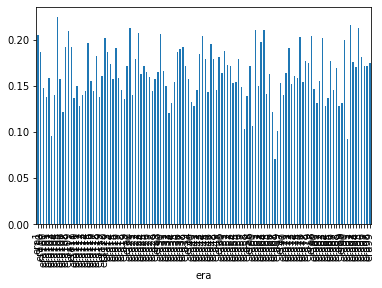

2021-02-07 19:19:04,127 INFO numexpr.utils: Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-02-07 19:19:04,128 INFO numexpr.utils: NumExpr defaulting to 8 threads.


train_mean                   0.499997
train_std_dev                0.011976
train_less_than_half         0.508681
train_less_than_mean         0.508593
train_autocorrelation        0.125121
train_mean correlation       0.162831
train_Median Correlation     0.161583
train_Variance               0.000847
train_Std. Dev.              0.029095
train_sharpe                 5.596452
train_smart sharpe           4.919611
train_Numerai sharpe        18.146648
dtype: float64
False
predicting per-era scores...
(501808, 314)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


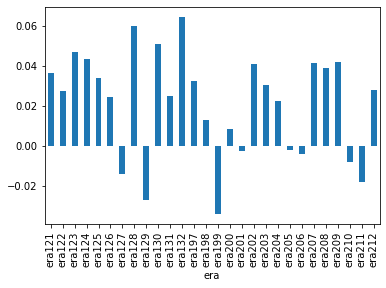

val_mean                  0.500268
val_std_dev               0.011929
val_less_than_half        0.502047
val_less_than_mean        0.511846
val_autocorrelation      -0.038305
val_mean correlation      0.021447
val_Median Correlation    0.027694
val_Variance              0.000668
val_Std. Dev.             0.025851
val_sharpe                0.829622
val_smart sharpe          0.845342
val_Numerai sharpe        1.478240
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----mlp_1----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


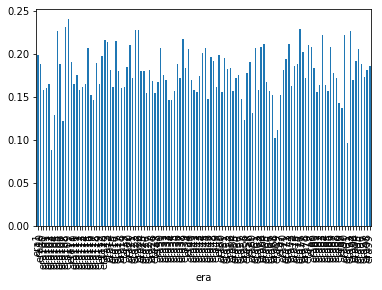

train_mean                   0.499997
train_std_dev                0.011806
train_less_than_half         0.506760
train_less_than_mean         0.506632
train_autocorrelation        0.108295
train_mean correlation       0.177614
train_Median Correlation     0.177173
train_Variance               0.000831
train_Std. Dev.              0.028831
train_sharpe                 6.160455
train_smart sharpe           5.507766
train_Numerai sharpe        20.089056
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


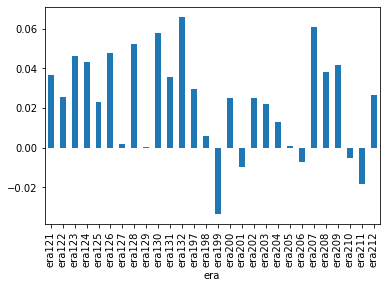

val_mean                  0.500211
val_std_dev               0.011539
val_less_than_half        0.502030
val_less_than_mean        0.510792
val_autocorrelation       0.052997
val_mean correlation      0.023170
val_Median Correlation    0.025364
val_Variance              0.000624
val_Std. Dev.             0.024976
val_sharpe                0.927685
val_smart sharpe          0.865549
val_Numerai sharpe        1.769048
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----mlp_3----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


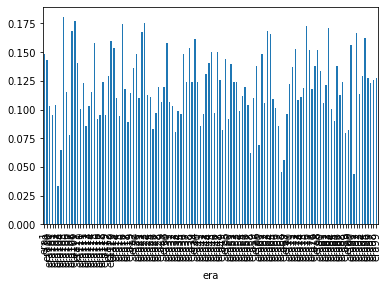

train_mean                   0.499997
train_std_dev                0.008474
train_less_than_half         0.509045
train_less_than_mean         0.508870
train_autocorrelation        0.113966
train_mean correlation       0.119562
train_Median Correlation     0.119094
train_Variance               0.000934
train_Std. Dev.              0.030569
train_sharpe                 3.911210
train_smart sharpe           3.476974
train_Numerai sharpe        12.368574
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


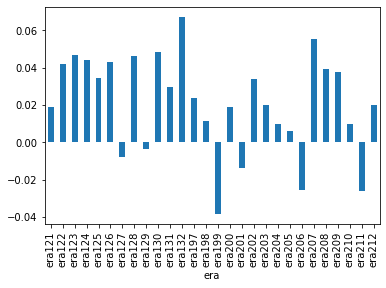

val_mean                  0.500203
val_std_dev               0.008433
val_less_than_half        0.501484
val_less_than_mean        0.512284
val_autocorrelation       0.033144
val_mean correlation      0.021093
val_Median Correlation    0.022063
val_Variance              0.000681
val_Std. Dev.             0.026093
val_sharpe                0.808354
val_smart sharpe          0.768812
val_Numerai sharpe        1.417517
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----mlp_4----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


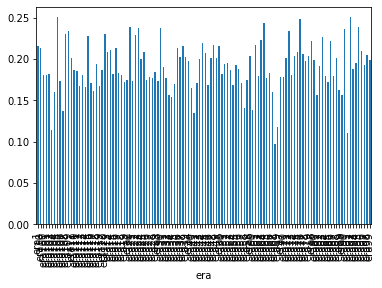

train_mean                   0.499997
train_std_dev                0.012685
train_less_than_half         0.508139
train_less_than_mean         0.508043
train_autocorrelation        0.113635
train_mean correlation       0.190827
train_Median Correlation     0.189733
train_Variance               0.000867
train_Std. Dev.              0.029446
train_sharpe                 6.480590
train_smart sharpe           5.763009
train_Numerai sharpe        21.224152
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


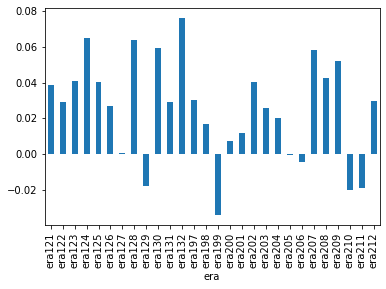

val_mean                  0.500366
val_std_dev               0.012501
val_less_than_half        0.499308
val_less_than_mean        0.511412
val_autocorrelation       0.043138
val_mean correlation      0.025351
val_Median Correlation    0.029127
val_Variance              0.000789
val_Std. Dev.             0.028090
val_sharpe                0.902496
val_smart sharpe          0.850106
val_Numerai sharpe        1.841928
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----mlp_5----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


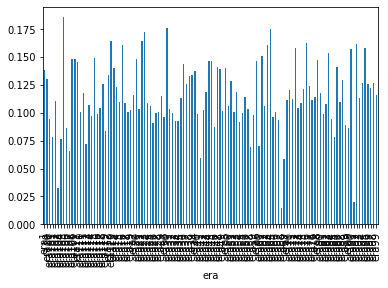

train_mean                   0.500026
train_std_dev                0.009448
train_less_than_half         0.513272
train_less_than_mean         0.514358
train_autocorrelation        0.024472
train_mean correlation       0.115336
train_Median Correlation     0.112094
train_Variance               0.000935
train_Std. Dev.              0.030579
train_sharpe                 3.771725
train_smart sharpe           3.665906
train_Numerai sharpe        11.885776
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


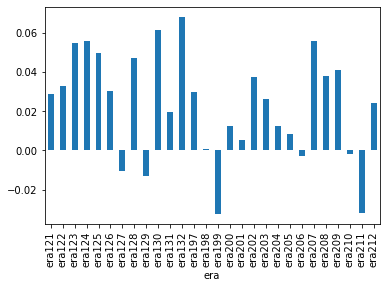

val_mean                  0.500271
val_std_dev               0.009434
val_less_than_half        0.505278
val_less_than_mean        0.517153
val_autocorrelation       0.107266
val_mean correlation      0.023087
val_Median Correlation    0.027484
val_Variance              0.000717
val_Std. Dev.             0.026780
val_sharpe                0.862094
val_smart sharpe          0.763101
val_Numerai sharpe        1.639132
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...

----mlp_6----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


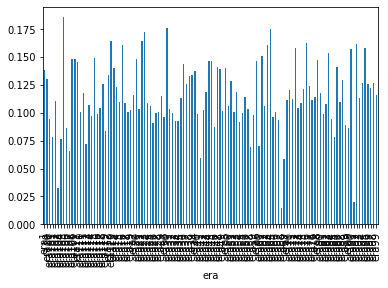

train_mean                   0.500026
train_std_dev                0.009448
train_less_than_half         0.513272
train_less_than_mean         0.514358
train_autocorrelation        0.024472
train_mean correlation       0.115336
train_Median Correlation     0.112094
train_Variance               0.000935
train_Std. Dev.              0.030579
train_sharpe                 3.771725
train_smart sharpe           3.665906
train_Numerai sharpe        11.885776
dtype: float64
False
predicting per-era scores...
(501808, 315)
Neutralizing...
Calculating Feature Exposure...
Drawdown...
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


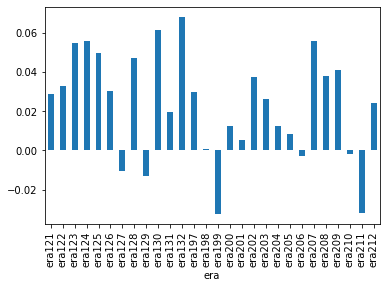

val_mean                  0.500271
val_std_dev               0.009434
val_less_than_half        0.505278
val_less_than_mean        0.517153
val_autocorrelation       0.107266
val_mean correlation      0.023087
val_Median Correlation    0.027484
val_Variance              0.000717
val_Std. Dev.             0.026780
val_sharpe                0.862094
val_smart sharpe          0.763101
val_Numerai sharpe        1.639132
dtype: float64
True
predicting per-era scores...
(137779, 314)
Neutralizing...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Calculating Feature Exposure...
Drawdown...
CPU times: user 31min 23s, sys: 14min 7s, total: 45min 31s
Wall time: 14min 32s


In [ ]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics
    
    gc.collect()
    

In [ ]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,mlp_2,mlp_1,mlp_3,mlp_4,mlp_5,mlp_6
train_mean,0.499997,0.499997,0.499997,0.499997,0.500026,0.500026
train_std_dev,0.011976,0.011806,0.008474,0.012685,0.009448,0.009448
train_less_than_half,0.508681,0.506760,0.509045,0.508139,0.513272,0.513272
train_less_than_mean,0.508593,0.506632,0.508870,0.508043,0.514358,0.514358
train_autocorrelation,0.125121,0.108295,0.113966,0.113635,0.024472,0.024472
train_mean correlation,0.162831,0.177614,0.119562,0.190827,0.115336,0.115336
train_Median Correlation,0.161583,0.177173,0.119094,0.189733,0.112094,0.112094
train_Variance,0.000847,0.000831,0.000934,0.000867,0.000935,0.000935
train_Std. Dev.,0.029095,0.028831,0.030569,0.029446,0.030579,0.030579
train_sharpe,5.596452,6.160455,3.911210,6.480590,3.771725,3.771725


In [ ]:
metric_trans = metric_df.T
metric_trans["val_Numerai sharpe"] > 1

mlp_2    True
mlp_1    True
mlp_3    True
mlp_4    True
mlp_5    True
mlp_6    True
Name: val_Numerai sharpe, dtype: bool